# курсовой проект 

Загружаем основные нужные библиотеки:

In [1]:
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

matplotlib.rcParams.update({'font.size': 12})

In [2]:
import warnings
warnings.filterwarnings('ignore')

Создаем пути к директориям и файлам:

In [3]:
TRAIN_DATASET_PATH = 'train.csv'

TEST_DATASET_PATH = 'test.csv'
TEST_DATASET_EXT_PATH = 'ERazdumina_predictions.csv'

Загружаем датасет:

In [4]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [5]:
df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

Смотрим распределение количественных признаков: 

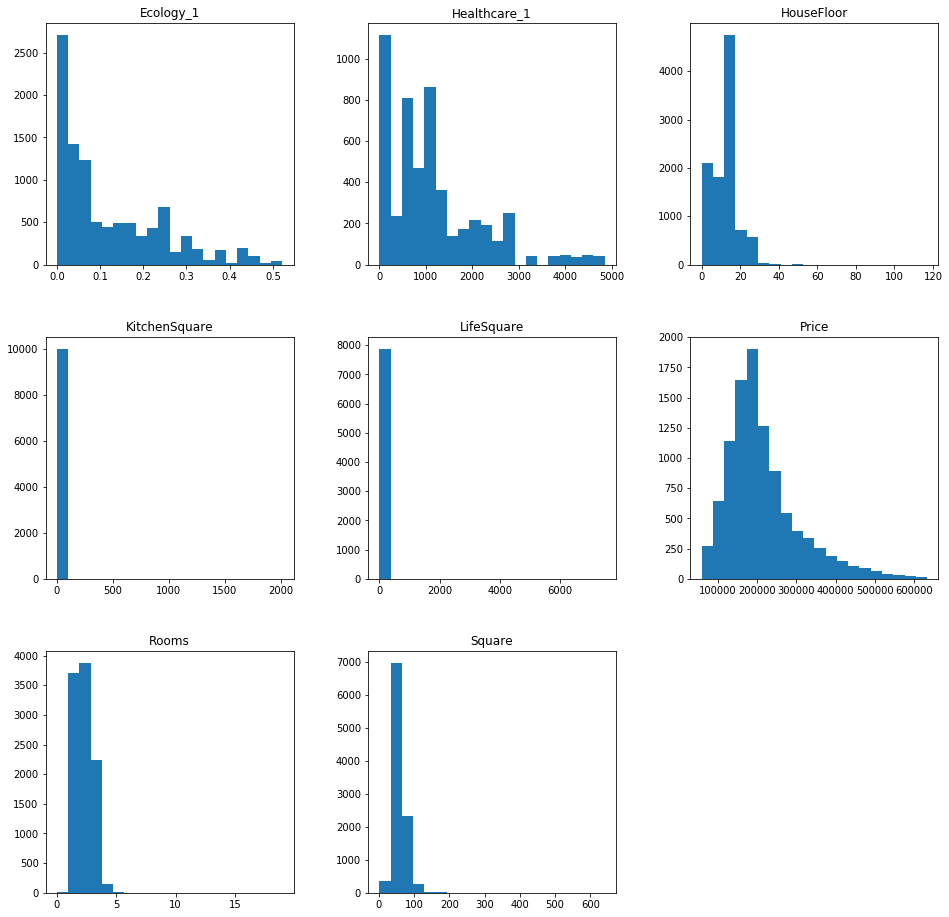

In [6]:
df_num_features = df.select_dtypes(include='float64')
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

Построим матрицу корреляции: 

In [7]:
df.corr()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
Id,1.000000,0.012973,-0.005847,-0.010071,0.018449,0.019880,0.001348,-0.008376,0.005004,0.018097,-0.000772,-0.002033,-0.009358,-0.003879,0.001502,-0.008718,0.009880
DistrictId,0.012973,1.000000,0.071432,-0.026613,-0.019910,0.040358,-0.120373,-0.149051,0.013430,0.065294,0.246463,0.167479,0.136095,0.304335,0.306147,0.174214,0.265100
Rooms,-0.005847,0.071432,1.000000,0.662893,0.131336,0.005123,-0.000665,-0.029302,-0.010612,-0.032347,0.075980,0.071335,0.012811,0.042857,0.063557,0.053618,0.550291
Square,-0.010071,-0.026613,0.662893,1.000000,0.196129,0.008320,0.114791,0.081505,-0.009032,-0.064479,-0.070690,-0.043120,0.035241,-0.039748,-0.022960,0.021357,0.520075
LifeSquare,0.018449,-0.019910,0.131336,0.196129,1.000000,-0.001195,0.024559,0.027442,-0.002210,-0.023629,-0.048363,-0.039283,0.012763,-0.026867,-0.024762,-0.007569,0.081292
KitchenSquare,0.019880,0.040358,0.005123,0.008320,-0.001195,1.000000,-0.011397,0.000780,0.000958,-0.005622,0.043379,0.037805,-0.015140,0.009472,0.043170,0.010216,0.028864
Floor,0.001348,-0.120373,-0.000665,0.114791,0.024559,-0.011397,1.000000,0.418986,0.000928,-0.016133,-0.044914,-0.016560,-0.002237,-0.138294,-0.065537,0.024264,0.128715
HouseFloor,-0.008376,-0.149051,-0.029302,0.081505,0.027442,0.000780,0.418986,1.000000,-0.000864,-0.004362,-0.020801,0.007194,-0.008137,-0.143973,-0.068728,0.026279,0.088280
HouseYear,0.005004,0.013430,-0.010612,-0.009032,-0.002210,0.000958,0.000928,-0.000864,1.000000,0.001465,0.003026,0.001970,0.000819,-0.011969,0.011245,0.003681,0.004305
Ecology_1,0.018097,0.065294,-0.032347,-0.064479,-0.023629,-0.005622,-0.016133,-0.004362,0.001465,1.000000,0.026464,0.009264,-0.124068,-0.043547,0.030873,-0.076749,-0.058381


Начнем готовить данные к постройке модели.
Сначала посмотрим описание датасета: 

In [8]:
df.shape

(10000, 20)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [10]:
df_num_features = df.select_dtypes(include=['float64', 'int64'])
df_num_features.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,NaN,0,11,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,23,5735,3,1084.0,0,5,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2078.0,2,4,150226.531644


In [11]:
df_num_features.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [12]:
df_obj_features = df.select_dtypes(include='object')
df_obj_features.head()

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,B


Обработаем пропущенные данные: 

In [13]:
len(df) - df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Заполняем пропущенные значения и обработаем выбросы: 

In [14]:
df_Healthcare_1_median = df['Healthcare_1'].median()

In [15]:
df_Rooms_median = df['Rooms'].median()

In [16]:
def fill_data(df):
    df.loc[(df['Square'] < df['LifeSquare']) | (df['LifeSquare'].isna()), 'LifeSquare'] = \
    (df.loc[(df['Square'] < df['LifeSquare']) | (df['LifeSquare'].isna()), 'Square'] - \
    df.loc[(df['Square'] < df['LifeSquare']) | (df['LifeSquare'].isna()), 'KitchenSquare'])*0.7
    
    df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df_Healthcare_1_median

    df.loc[df['Rooms'] > 10, 'Rooms'] = df_Rooms_median
    
    return df

In [17]:
df = fill_data(df) 

Преобразуем категориальные признаки: 

In [18]:
df_train = pd.get_dummies(df) 

Проверим датасет перед сохранением: 

In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     10000 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Price            10000 non-null float64
Ecology_2_A      10000 non-null uint8
Ecology_2_B      10000 non-null uint8
Ecology_3_A      10000 non-null uint8
Ecology_3_B      10000 non-null uint8
Shops_2_A        10000 non-null uint8
Shops_2_B        10000 non-null uint8
dt

Отберем признаки: 

In [20]:
df_train.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Price',
       'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A',
       'Shops_2_B'],
      dtype='object')

In [21]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 
       'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A',
       'Shops_2_B']
target_name = ['Price']

In [22]:
X = df_train[feature_names]
y = df_train[target_name]

Разобьем датасет на test и valid:

In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

Создадим пробную модель на разбитых данных, чтобы подобрать значения: 

In [24]:
r2_test = []
r2_train = []

max_depth_ = [12, 16, 18, 20]

for max_depth in max_depth_:
    model = RandomForestRegressor(max_depth=max_depth, n_estimators=100, random_state=42)
    model.fit(X_train,y_train)
    predict_price = model.predict(X_valid)
    r2_test.append(r2(y_valid.values.flatten(), predict_price))
    predict_price_train = model.predict(X_train)
    r2_train.append(r2(y_train.values.flatten(), predict_price_train))

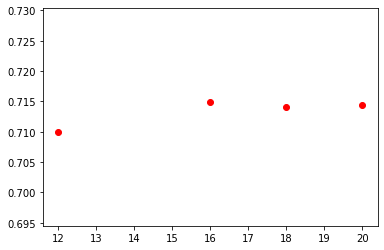

In [25]:
plt.scatter(max_depth_, r2_test, c = 'r')

In [26]:
model_valid = RandomForestRegressor(max_depth=16, n_estimators=100, random_state=42)

In [27]:
model_valid.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=16,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [28]:
train_pred_values = model_valid.predict(X_train)
test_pred_values = model_valid.predict(X_valid)

Train R2:	0.943
Test R2:	0.715


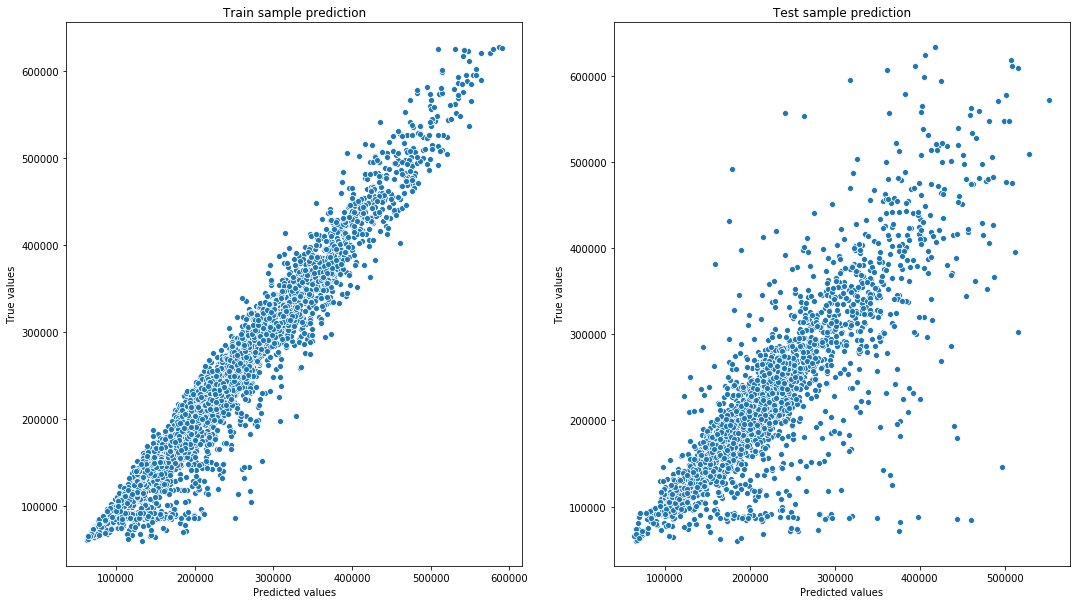

In [29]:
print("Train R2:\t" + str(round(r2(y_train.values.flatten(), train_pred_values), 3)))
print("Test R2:\t" + str(round(r2(y_valid.values.flatten(), test_pred_values), 3)))
    
plt.figure(figsize=(18,10))
    
plt.subplot(121)
sns.scatterplot(x=train_pred_values, y=y_train.values.flatten())
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Train sample prediction')
    
plt.subplot(122)
sns.scatterplot(x=test_pred_values, y=y_valid.values.flatten())
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Test sample prediction')

plt.show()

In [30]:
final_model = RandomForestRegressor(max_depth=16, n_estimators=100, random_state=42)

In [31]:
final_model.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=16,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

Подготовим тестовые данные: 

In [32]:
df_test = pd.read_csv(TEST_DATASET_PATH)

In [33]:
df_test = fill_data(df_test)
df_test = pd.get_dummies(df_test)

In [34]:
df_test.shape

(5000, 22)

In [35]:
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,1,900.0,0,0,0,1,0,1,0,1
1,15856,74,2.0,69.263183,47.784228,1.0,6,1.0,1977,0.075779,...,3,900.0,0,2,0,1,0,1,0,1
2,5480,190,1.0,13.597819,1.118473,12.0,2,5.0,1909,0.000000,...,87,4702.0,5,5,0,1,0,1,0,1
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,3,900.0,3,3,0,1,0,1,0,1
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,1,900.0,0,0,0,1,0,1,1,0


In [36]:
predict_test_price = final_model.predict(df_test[feature_names])

In [37]:
df_test['predict_price'] = predict_test_price
df_test[['Id', 'predict_price']].to_csv(TEST_DATASET_EXT_PATH, index = False)

In [38]:
df_test[['Id', 'predict_price']].head()

,Id,predict_price
0,725,162277.628548
1,15856,199448.923350
2,5480,222450.371381
3,15664,338728.298894
4,14275,138370.369924
